# mAP (mean Average Precision)

**mAP(mean Average Precision)**는 객체 탐지(Object Detection) 모델의 성능을 평가하는 표준 지표임. 이 지표는 모델이 얼마나 정확하게 객체의 위치를 예측(Localization)하고, 올바르게 분류(Classification)하는지를 종합적으로 측정함.

mAP는 각 클래스(Class)에 대한 **AP(Average Precision)**의 평균값으로, 단일 숫자로 모델의 전반적인 성능을 나타내주기 때문에 여러 모델을 비교하거나 하이퍼파라미터 튜닝의 기준으로 삼기에 매우 유용함.

### 📐 수학적 배경

mAP를 이해하기 위해서는 먼저 다음 개념들을 알아야 함.

1.  **IoU (Intersection over Union)**: 예측된 경계 상자(Predicted Bounding Box)와 실제 경계 상자(Ground Truth Box)가 얼마나 겹치는지를 나타내는 척도. 이 값이 특정 임계값(Threshold) 이상일 때 '올바른 예측'으로 간주함.
    $$ IoU = \frac{\text{Area of Overlap}}{\text{Area of Union}} $$

2.  **정밀도(Precision)와 재현율(Recall)**:
    * **정밀도**: 모델이 '양성(Positive)'이라고 예측한 것들 중 실제로 '양성'인 것의 비율. 즉, 예측의 정확성. 
        $$ \text{Precision} = \frac{TP}{TP + FP} = \frac{\text{True Positives}}{\text{Total Predicted Positives}} $$
    * **재현율**: 실제 '양성'인 것들 중 모델이 '양성'이라고 올바르게 예측한 것의 비율. 즉, 모델이 얼마나 빠짐없이 잘 찾아내는가. 
        $$ \text{Recall} = \frac{TP}{TP + FN} = \frac{\text{True Positives}}{\text{Total Actual Positives}} $$
        *TP: True Positive, FP: False Positive, FN: False Negative*

3.  **AP (Average Precision)**: 정밀도-재현율 곡선(Precision-Recall Curve)의 아래 면적(Area Under Curve). 모델의 신뢰도(Confidence Score) 임계값을 변경함에 따라 계산되는 모든 정밀도 값의 평균을 의미하며, 단일 클래스에 대한 모델의 성능을 나타냄.

4.  **mAP (mean Average Precision)**: 모든 클래스에 대한 AP 값의 평균.
    $$ mAP = \frac{1}{N} \sum_{i=1}^{N} AP_i \quad (N: \text{전체 클래스의 수}) $$

### 라이브러리 임포트 (Setup)

In [16]:
# !pip install numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### 예제 데이터 준비 (Data Preparation)

하나의 이미지에 대한 실제 객체 정보(`ground_truths`)와 모델의 예측 결과(`predictions`)를 가정함. 
* `ground_truths`: 실제 객체의 위치([x_min, y_min, x_max, y_max])와 레이블.
* `predictions`: 모델이 예측한 객체의 위치, 레이블, 그리고 해당 예측에 대한 신뢰도(confidence) 점수.

In [17]:
# 실제 객체 정보 (Ground Truths)
ground_truths = [
    {'box': [50, 50, 150, 150], 'label': 'cat'}, 
    {'box': [100, 100, 250, 250], 'label': 'cat'},
    {'box': [300, 300, 400, 400], 'label': 'dog'}
]

# 모델 예측 결과 (Predictions)
predictions = [
    {'box': [60, 60, 160, 160], 'label': 'cat', 'confidence': 0.95},
    {'box': [120, 110, 260, 240], 'label': 'cat', 'confidence': 0.88},
    {'box': [200, 50, 300, 150], 'label': 'cat', 'confidence': 0.70}, # 잘못된 예측 (FP)
    {'box': [310, 300, 410, 400], 'label': 'dog', 'confidence': 0.92},
    {'box': [50, 280, 150, 380], 'label': 'dog', 'confidence': 0.85}  # 잘못된 예측 (FP)
]

print(f"총 실제 객체 수: {len(ground_truths)}")
print(f"총 예측 수: {len(predictions)}")

총 실제 객체 수: 3
총 예측 수: 5


### IoU 계산 및 시각화 예시 🖼️

mAP 계산에 앞서, 개별 예측(빨간색 상자)이 모든 실제 객체(초록색 상자)와 각각 어느 정도의 IoU 값을 갖는지 시각적으로 확인합니다. 이는 특정 예측이 왜 TP 또는 FP로 판정되는지 직관적으로 이해하는 데 도움을 줍니다.

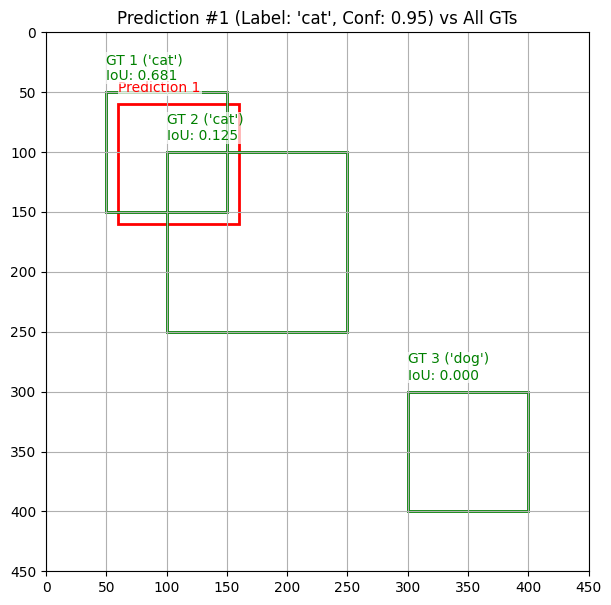

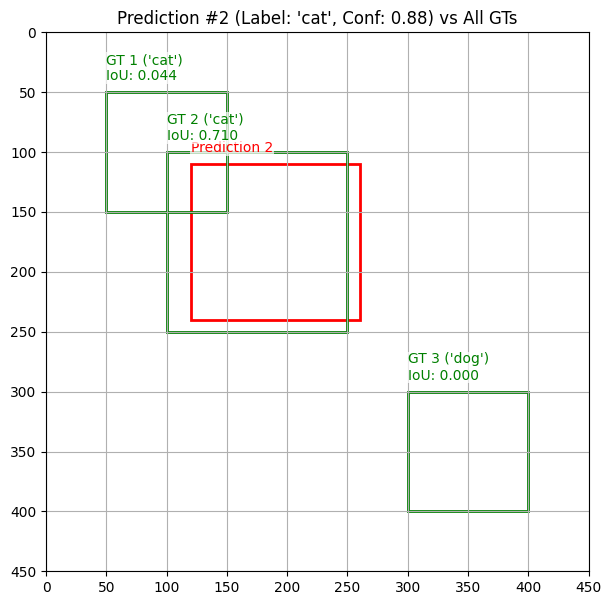

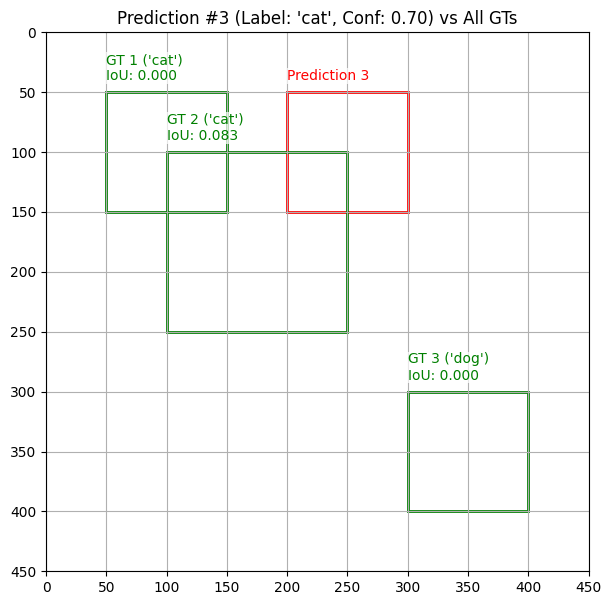

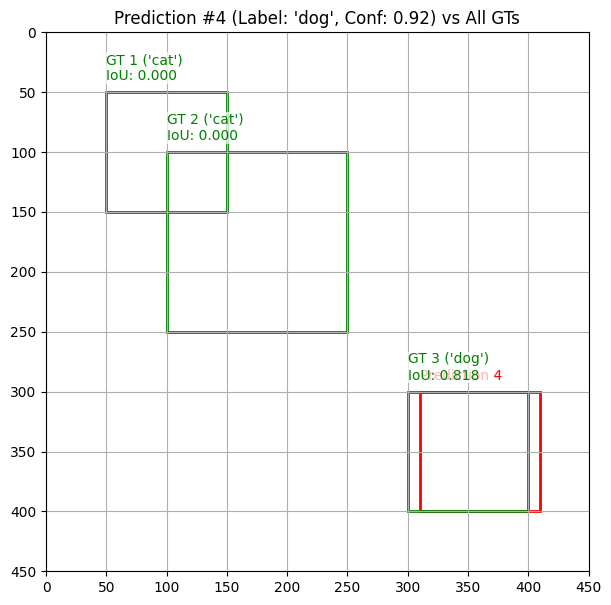

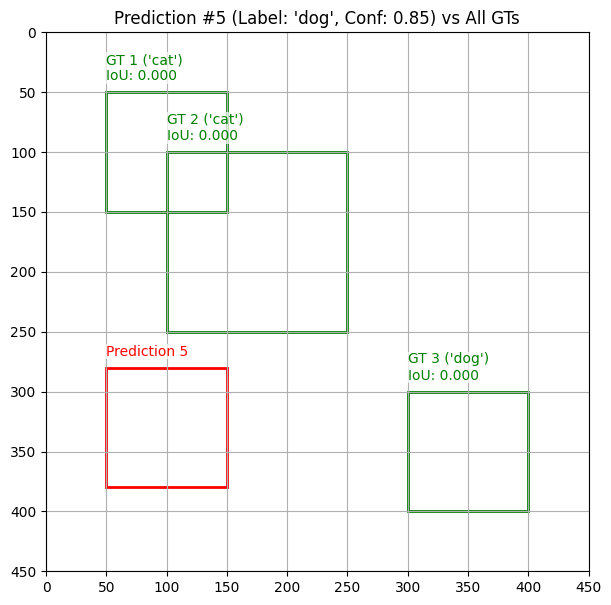

In [18]:
def calculate_iou(box1, box2):
    """두 경계 상자의 IoU를 계산하는 함수"""
    # box = [x_min, y_min, x_max, y_max]
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_width = max(0, x2_inter - x1_inter)
    inter_height = max(0, y2_inter - y1_inter)
    intersection_area = inter_width * inter_height

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def draw_box(ax, box_coords, color, label):
    """matplotlib 축에 경계 상자와 라벨을 그리는 함수"""
    x_min, y_min, x_max, y_max = box_coords
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min - 10, label, color=color, fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=0.5))

# 각 예측 상자별로 IoU 시각화
for i, pred in enumerate(predictions):
    fig, ax = plt.subplots(1, figsize=(7, 7))
    ax.set_title(f"Prediction #{i+1} (Label: '{pred['label']}', Conf: {pred['confidence']:.2f}) vs All GTs")

    # 예측 상자 그리기 (빨간색)
    draw_box(ax, pred['box'], 'red', f"Prediction {i+1}")

    # 모든 실제 상자를 그리고, 현재 예측과의 IoU를 표시 (초록색)
    for j, gt in enumerate(ground_truths):
        iou = calculate_iou(pred['box'], gt['box'])
        gt_label = f"GT {j+1} ('{gt['label']}')\nIoU: {iou:.3f}"
        draw_box(ax, gt['box'], 'green', gt_label)
    
    ax.set_xlim(0, 450)
    ax.set_ylim(450, 0) # 이미지 좌표계처럼 좌상단을 (0,0)으로 설정
    plt.grid(True)
    plt.show()

### 핵심 로직 구현 (Code Implementation)

#### 단계 1~4: 클래스별 AP(Average Precision) 계산

각 클래스에 대해 다음 과정을 수행함.
1.  해당 클래스의 모든 예측을 신뢰도 점수(confidence score) 기준으로 내림차순 정렬.
2.  정렬된 예측을 순회하며 각 예측에 대해 가장 IoU가 높은 실제 객체(Ground Truth)를 찾음.
3.  IoU가 임계값(여기서는 0.5) 이상이고, 해당 실제 객체가 아직 다른 예측과 매칭되지 않았다면 **TP(True Positive)**로 기록. 그렇지 않으면 **FP(False Positive)**로 기록.
4.  누적 TP와 FP를 기반으로 각 예측 지점에서 정밀도(Precision)와 재현율(Recall)을 계산.
5.  계산된 정밀도-재현율 값을 이용해 AP(Average Precision)를 계산.

In [19]:
def calculate_ap_for_class(predictions, ground_truths, class_label, iou_threshold=0.5):
    """특정 클래스에 대한 AP를 계산하는 함수"""
    
    # 해당 클래스의 예측과 실제 객체만 필터링
    class_preds = sorted([p for p in predictions if p['label'] == class_label], key=lambda x: x['confidence'], reverse=True)
    class_gts = [gt for gt in ground_truths if gt['label'] == class_label]
    
    if len(class_gts) == 0:
        return 0.0, [], []

    # 각 실제 객체가 매칭되었는지 추적
    gt_matched = [False] * len(class_gts)
    
    tp_list = np.zeros(len(class_preds))
    fp_list = np.zeros(len(class_preds))
    
    # 예측을 순회하며 TP, FP 판정
    for i, pred in enumerate(class_preds):
        best_iou = -1
        best_gt_idx = -1

        for j, gt in enumerate(class_gts):
            if gt['label'] == class_label: # 레이블이 같은 GT만 비교
                iou = calculate_iou(pred['box'], gt['box'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
        
        # TP/FP 판정 (해당 GT가 같은 클래스인지 한번 더 확인하는 로직은 이미 class_gts 필터링으로 처리됨)
        # gt_map에서 인덱스를 가져와야 하므로, 전체 ground_truths 기준 인덱스를 찾아야 함.
        # 이 예제에서는 class_gts를 새로 만들었으므로 로컬 인덱스(best_gt_idx)를 사용함.
        if best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
            tp_list[i] = 1
            gt_matched[best_gt_idx] = True # 한번 매칭된 GT는 다시 사용 불가
        else:
            fp_list[i] = 1
            
    # 누적 TP, FP 계산
    cumulative_tp = np.cumsum(tp_list)
    cumulative_fp = np.cumsum(fp_list)
    
    # 정밀도 및 재현율 계산
    recall = cumulative_tp / len(class_gts)
    precision = cumulative_tp / (cumulative_tp + cumulative_fp)
    
    print(f"--- 클래스: {class_label} ---")
    print(f"신뢰도 순 예측: {[round(p['confidence'], 2) for p in class_preds]}")
    print(f"TP/FP 판정:     {[('TP' if t else 'FP') for t in tp_list]}")
    print(f"누적 정밀도: {[round(p, 2) for p in precision]}")
    print(f"누적 재현율: {[round(r, 2) for r in recall]}")

    # AP 계산 (Area under PR curve)
    recall = np.concatenate(([0.], recall, [1.]))
    precision = np.concatenate(([0.], precision, [0.]))

    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
        
    recall_change_indices = np.where(recall[1:] != recall[:-1])[0]
    ap = np.sum((recall[recall_change_indices + 1] - recall[recall_change_indices]) * precision[recall_change_indices + 1])
    
    return ap, precision, recall


#### 단계 5: 최종 mAP 계산 및 결과 시각화

--- 클래스: cat ---
신뢰도 순 예측: [0.95, 0.88, 0.7]
TP/FP 판정:     ['TP', 'TP', 'FP']
누적 정밀도: [np.float64(1.0), np.float64(1.0), np.float64(0.67)]
누적 재현율: [np.float64(0.5), np.float64(1.0), np.float64(1.0)]
--- 클래스: dog ---
신뢰도 순 예측: [0.92, 0.85]
TP/FP 판정:     ['TP', 'FP']
누적 정밀도: [np.float64(1.0), np.float64(0.5)]
누적 재현율: [np.float64(1.0), np.float64(1.0)]

--- 최종 결과 ---
cat AP: 1.0000
dog AP: 1.0000

IoU 임계값 @ 0.5
mAP: 1.0000


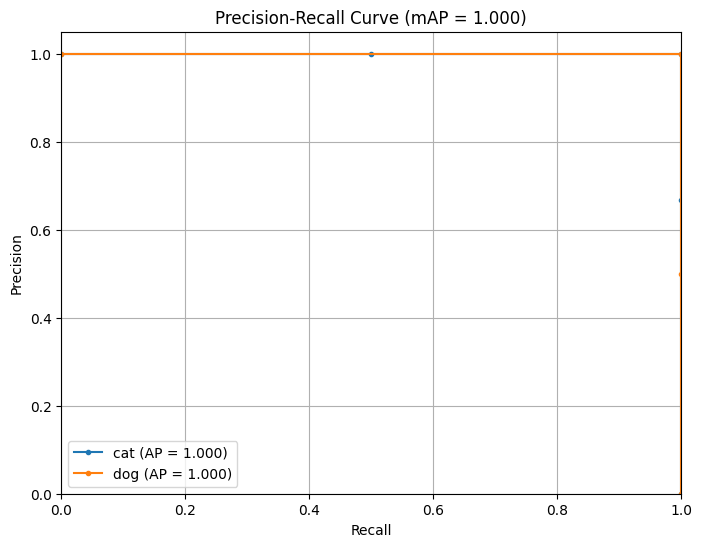

In [20]:
all_classes = sorted(list(set([p['label'] for p in predictions] + [gt['label'] for gt in ground_truths])))
ap_dict = {}
iou_threshold = 0.5

plt.figure(figsize=(8, 6))

# 각 클래스에 대해 AP 계산 및 PR 곡선 그리기
for class_label in all_classes:
    ap, precision, recall = calculate_ap_for_class(predictions, ground_truths, class_label, iou_threshold)
    ap_dict[class_label] = ap
    plt.plot(recall, precision, marker='.', label=f'{class_label} (AP = {ap:.3f})')

# mAP 계산
mAP = np.mean(list(ap_dict.values()))

print("\n--- 최종 결과 ---")
for class_label, ap in ap_dict.items():
    print(f"{class_label} AP: {ap:.4f}")
    
print(f"\nIoU 임계값 @ {iou_threshold}")
print(f"mAP: {mAP:.4f}")

# 그래프 설정
plt.title(f'Precision-Recall Curve (mAP = {mAP:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.show()

### 📊 결과 확인 및 시각화

위 코드를 실행하면 각 클래스('cat', 'dog')에 대한 AP(Average Precision)와 최종 mAP가 출력됨.

* **'cat' 클래스**: 3개의 예측 중 2개는 실제 객체와 잘 매칭되어 TP, 1개는 잘못된 위치에 있어 FP로 판정됨. 재현율이 0.5(2개 중 1개 찾음)일 때의 정밀도는 1.0, 재현율이 1.0(2개 중 2개 찾음)일 때의 정밀도는 0.67(3개 예측 중 2개 성공)이 됨. 이를 바탕으로 AP가 계산됨.
* **'dog' 클래스**: 2개의 예측 중 1개는 TP, 1개는 FP임. 실제 객체가 1개이므로 최대 재현율은 1.0이 됨. AP는 재현율이 1.0일 때의 정밀도 값과 동일하게 계산됨.

**Precision-Recall Curve**는 모델의 성능을 직관적으로 보여줌. 이상적인 모델은 재현율이 증가해도 정밀도가 1.0에 가깝게 유지되므로, 곡선이 오른쪽 상단에 가깝게 그려짐. 곡선 아래의 면적인 AP가 클수록 해당 클래스에 대한 성능이 우수함을 의미함.

### 고려사항 (Considerations)

* **IoU 임계값**: mAP 값은 IoU 임계값에 크게 의존함. 임계값을 높이면(예: 0.75) 모델이 더 정확하게 객체의 위치를 예측해야 하므로 mAP 점수가 낮아짐. PASCAL VOC 데이터셋은 주로 `mAP@0.5`를 사용하고, COCO 데이터셋은 `0.5`부터 `0.95`까지 0.05 간격으로 여러 임계값에 대한 mAP를 측정하여 평균낸 값을 주요 지표로 사용함.
* **데이터셋의 클래스 불균형**: 특정 클래스의 객체가 다른 클래스보다 훨씬 많은 경우, mAP는 다수 클래스의 성능에 더 큰 영향을 받을 수 있음. 클래스별 AP를 함께 확인하여 모델이 소수 클래스에 대해서도 준수한 성능을 보이는지 검토해야 함.

### 최종 요약 (Conclusion)

**mAP(mean Average Precision)**는 객체 탐지 모델의 분류 정확도(정밀도)와 탐지 능력(재현율)을 종합적으로 평가하는 강력한 지표임. 신뢰도 점수에 따라 예측을 정렬하고, IoU를 통해 예측의 성공 여부를 판단하여 정밀도-재현율 곡선을 그림으로써 단일 값으로 모델의 성능을 정량화함.

본 예제에서는 개별 IoU 값의 시각화를 통해 TP/FP 판정의 근거를 직관적으로 확인하고, 이 판정들이 모여 각 클래스의 AP와 최종 mAP를 구성하는 전 과정을 단계별로 구현함. 이를 통해 mAP가 어떻게 모델의 예측 품질을 다각도에서 측정하는지 이해할 수 있음.